## Introduction

In Dr. Israni's examples on convergence diagnoses, coda was introduced to transform stan fit data and calc stats with the data. As I am exposed to more bayesian methods, I found stan might not be the go-to package for python as there is not so much support from third-party libraries as in R. So in the notebook, I am going to introduce limited ways to

1. Diagnose with PyStan
2. Diagnose with PyMC3

Alright, let's cut the sh*t, and get started!

In [6]:
import pystan
from pystan import StanModel
from stan_utils import StanModel_cache
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

CWD = '/Users/chengluli/developer/applied_bayesian'
os.chdir(CWD)

sns.set(style="white", palette="muted", color_codes=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# install pymc3 and graphviz (graphviz is cool! you will see)
!pip install pymc3
!conda install -c conda-forge python-graphviz

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.6.3
  latest version: 4.6.12

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



## PyStan and Arviz

In [5]:
# Simple model from example1

model_code = """
data {
  int<lower=0> N;
  real Y[N]; // Scores of 20 students in an array
}

parameters {
  real mu;
  real<lower=0> sigma;
}

model {
  Y ~ normal(mu,sigma); // Likelihood
  mu ~ normal(0,100); // Prior for mu
  sigma ~ cauchy(0,100); // Prior for sigma
}
"""

N = 200
Y = np.random.normal(size=N, loc=10, scale=5)

data = {"Y": Y, "N": N}

# model is cached so that you can load super fast for any session afterwards
sm = StanModel_cache(model_code=model_code)  #can specify cores for parallelization
fit = sm.sampling(data=data, warmup=500, iter=1000, chains=4, verbose=True)
print(fit)

Using cached StanModel
Inference for Stan model: anon_model_8d03e3d83999d56e8e9f083dd1b8fc08.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      9.53  8.1e-3   0.33   8.88   9.31   9.53   9.76  10.18   1696    1.0
sigma   4.92  5.7e-3   0.25   4.46   4.75    4.9   5.08   5.46   1897    1.0
lp__  -416.4    0.03   0.97 -418.9 -416.7 -416.1 -415.7 -415.4    824    1.0

Samples were drawn using NUTS at Tue Apr 16 14:49:12 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Diagnoses

In the example of `codaBin.r`, the following analysis was conducted:

```r
fit.mcmc = stan2coda(fit) # transform stan fit to coda object
traceplot(fit.mcmc)
effectiveSize(fit.mcmc)

# new things we have not done before
crosscorr.plot(fit.mcmc)
autocorr.plot(fit.mcmc)
geweke.diag(fit.mcmc)
gelman.diag(fit.mcmc)
heidel.diag(fit.mcmc)
raftery.diag(fit.mcmc)
gelman.plot(fit.mcmc)
```

There are several things we have not covered in the example1 file: `crosscorr, autocorr, geweke, gelman, heidel, raftery`. Unfortunately, we can only do `autocorr, geweke, and gelman` with PyStan and Arviz. But `heidel` and `raftery` are basically used for the same purpose as `geweke`, I guess it is not the end of world. It would be nice if we can compute crosscorrelation though.

In [8]:
# transform stan fit to arviz data
data = az.from_pystan(fit)

#### Autocorrelation (ACF)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20ef7f98>,
      dtype=object)

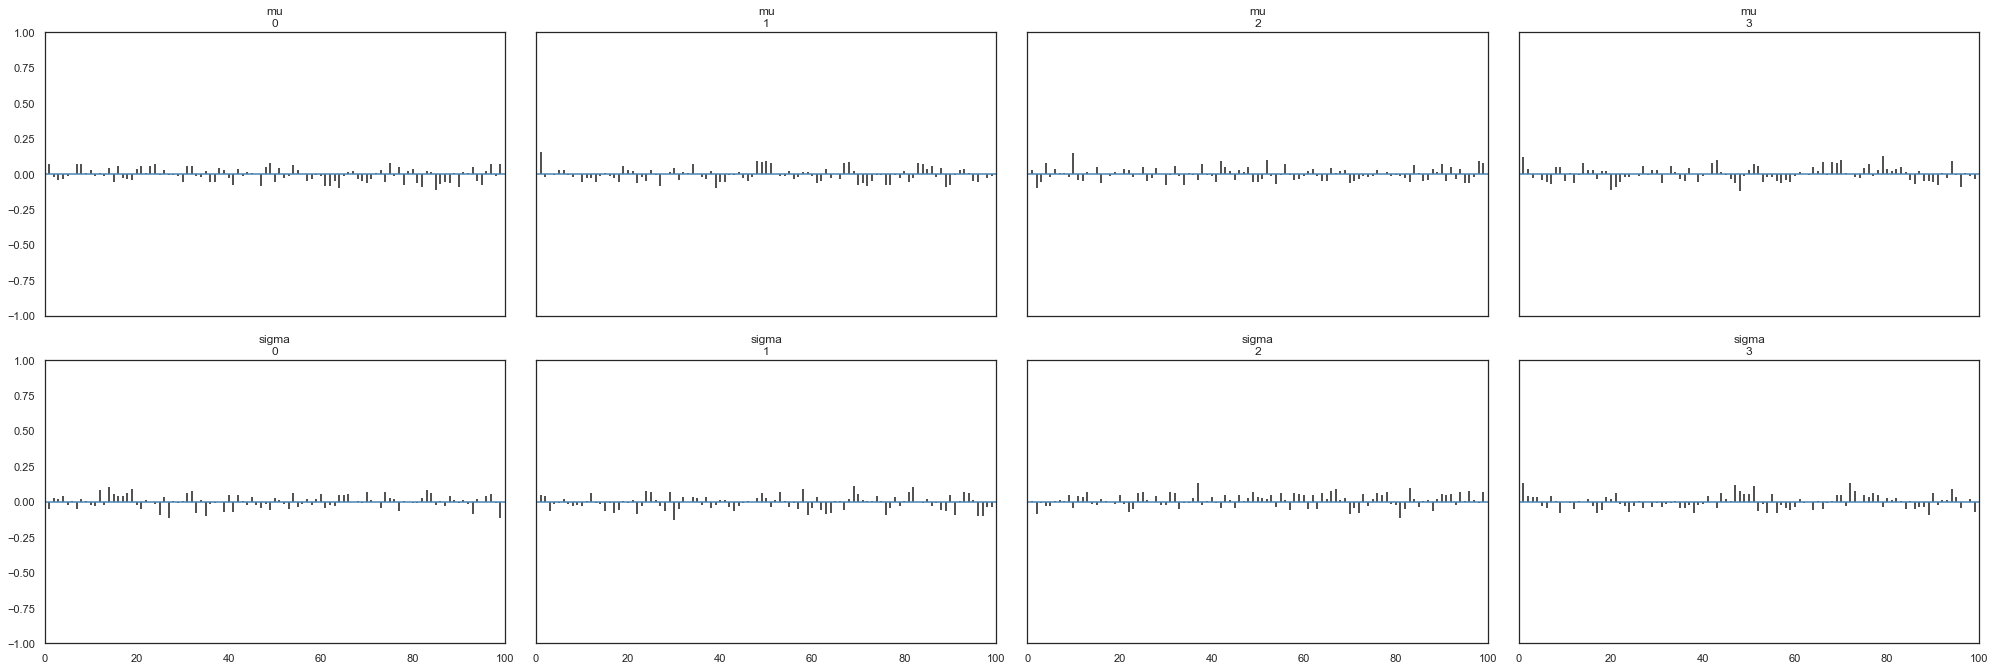

In [34]:
# autocorrelation plot
# you know how to do traceplot from example1, or check the doc: 
# https://arviz-devs.github.io/arviz/generated/arviz.plot_trace.html#arviz.plot_trace
az.plot_autocorr(data)

In [16]:
# autocorrelation stats
# notice we are not using the arviz data object here, because that autocorr requires an array as argument
# and it is simply easy to get such an array from stan fit
az.autocorr(fit['mu'])

array([ 1.        , -0.02598461,  0.03081264, ..., -0.48294584,
       -1.12308372, -0.7624559 ])

#### geweke

In [29]:
# You can also optionally specify named param first=FLOAT_LESS_THAN_1, last=FLOAT_LESS_THAN_1, the default is first=0.1, last=0.5

# Return a list of [i, score], where i is the starting index for each interval and score the Geweke score on the interval.
# for example, [ 5.20000000e+01, -5.52162324e-02] means the i = 52, and the score is -5.5216...
az.geweke(fit['mu'])

array([[ 0.00000000e+00, -1.27186949e-02],
       [ 5.20000000e+01, -5.52162324e-02],
       [ 1.05000000e+02, -9.74378671e-02],
       [ 1.57000000e+02, -5.49204019e-02],
       [ 2.10000000e+02,  8.84289318e-04],
       [ 2.63000000e+02, -3.78176584e-02],
       [ 3.15000000e+02, -2.52324364e-02],
       [ 3.68000000e+02, -4.11734654e-03],
       [ 4.20000000e+02, -6.26857385e-02],
       [ 4.73000000e+02, -3.43824652e-02],
       [ 5.26000000e+02, -1.85789442e-02],
       [ 5.78000000e+02,  1.28339841e-02],
       [ 6.31000000e+02,  2.63344595e-03],
       [ 6.83000000e+02,  1.88580937e-02],
       [ 7.36000000e+02, -1.02899351e-02],
       [ 7.89000000e+02,  5.19818025e-02],
       [ 8.41000000e+02, -3.40784382e-02],
       [ 8.94000000e+02, -2.37215562e-02],
       [ 9.46000000e+02, -7.47682122e-02],
       [ 9.99000000e+02, -2.04560332e-01]])

#### gelman & rubin

In [39]:
# gelma & rubin
# 1.0 rhat val for both mu and sigma
az.rhat(data)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 1.0
    sigma    float64 1.0

## PyMC3

Same as stan, PyMC3 also uses NUTS, which is the state-of-the-art way of sampling. PyMC3 uses Theano behind the scene, which is a package for tensor. Wait, tensor, that sounds familiar! Well, it is the same meaning of what tensor in tensorflow means: generalized matrix. Theano uses c behind the scene, so it also has a good efficiency in terms of computation (actually, almost all the mainstream frameworks are architected above c or c++). If you decide you do not want to try PyMC3 now, it is totally fine, because it is not perfect (for bayesian, R offers much more packages that build on top of each other. But you can only find commonly used solutions in python). However, **do check with PyMC4, because it will be built upon tensorflow instead of theano, which means much more possibilities as we can make use of the mature community of tensorflow**.

Personally I prefer pymc3, because it is more `pythonic`. I am sure you will appreciate the package if you have heavily used python for data analysis. Meanwhile, it is an all-in-one package, meaning you can do almost every common analysis using just one package.

In [43]:
import pymc3 as pm

N = 200
Y = np.random.normal(size=N, loc=10, scale=5)

with pm.Model() as model:
    # prior 1
    mu = pm.Normal('mu', mu=0, sd=100)
    
    # prior 2
    sigma = pm.HalfCauchy('sigma', 2.5)
    
    # likelihood
    # we need to pass in the named param "observed" in order
    # to make this a likelihood
    y = pm.Normal('y_likelihood', mu, sigma, observed=Y)

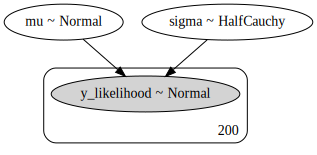

In [47]:
# Run it, and bang!
# if you run it with jupyter notebook instead of jupyter lab, then you will have to import the function display:
# from IPython.display import display
# Use the lab! It is the future :p
with model:
    display(pm.model_to_graphviz(model))

As you can see above, we can visualize our model very easily. It might not be so helpful here since the model is simple, but imagine you are doing hierarchical modeling...and how visualization can help you know if you are on the right track.

In [48]:
# sampling
with model:
    trace = pm.sample(5000, tune=1000)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:05<00:00, 4247.80draws/s]


### Diagnoses

`Arviz` not only supports `PyStan`, but also supports `PyMC3`, so you can do everything above with
```python
data = az.from_pymc3(trace)
```

In [53]:
# get summary
# summary generation is much more flexible than stan, you can compute things that are not listed below
# see https://docs.pymc.io/api/stats.html to check docs on "summary"
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,10.205909,0.387109,0.002835,9.444527,10.959479,20848.964310,1.000065
sigma,5.404030,0.274316,0.001821,4.879118,5.944513,20180.584686,0.999946


#### traceplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2d0329e8>,
      dtype=object)

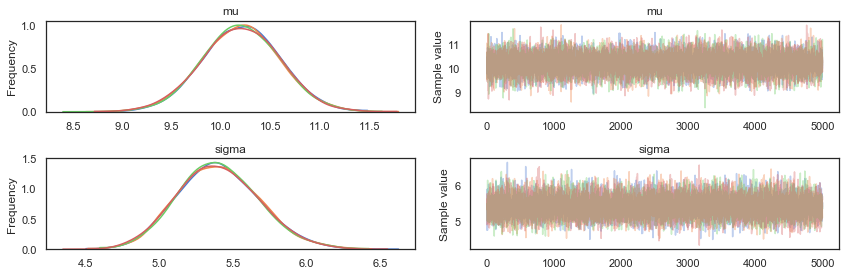

In [54]:
pm.traceplot(trace)

#### autocorrelation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2cfb8c50>,
      dtype=object)

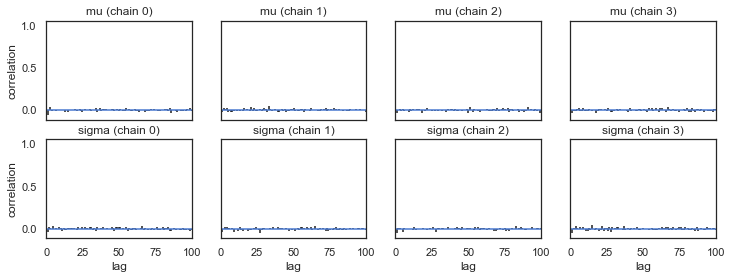

In [55]:
pm.autocorrplot(trace)

In [57]:
# you can throw in the trace object directly and get autocorrelation of all chains
pm.autocorr(trace)

{0: {'mu': array([ 1.        , -0.06004555,  0.00431107, ..., -0.00953871,
          0.00260782, -0.23941377]),
  'sigma_log__': array([ 1.        , -0.03937084,  0.02261912, ..., -0.27031097,
         -0.12702121, -0.3849934 ]),
  'sigma': array([ 1.        , -0.03712763,  0.023783  , ..., -0.21907351,
         -0.10678945, -0.36686227])},
 1: {'mu': array([ 1.        , -0.02516735,  0.02706685, ..., -0.04037049,
         -0.12690549, -0.07629685]),
  'sigma_log__': array([ 1.        , -0.03991203, -0.00949921, ..., -0.03280467,
          0.1578552 ,  0.223453  ]),
  'sigma': array([ 1.        , -0.03819692, -0.00809917, ..., -0.00771645,
          0.18350406,  0.2478299 ])},
 2: {'mu': array([ 1.        , -0.0342428 ,  0.00112397, ...,  1.0448771 ,
         -0.18886711, -0.22899806]),
  'sigma_log__': array([ 1.        , -0.04672766,  0.01262888, ..., -0.1882706 ,
          0.17387819,  0.28254046]),
  'sigma': array([ 1.        , -0.04644634,  0.01043082, ..., -0.1695874 ,
         

#### geweke

In [60]:
pm.geweke(trace)

{0: {'mu': array([[ 0.00000000e+00,  1.09765267e-02],
         [ 1.31000000e+02, -3.49795804e-02],
         [ 2.62000000e+02, -4.71616382e-02],
         [ 3.93000000e+02, -3.79329160e-02],
         [ 5.24000000e+02, -3.85259463e-02],
         [ 6.55000000e+02, -2.19066437e-02],
         [ 7.86000000e+02, -1.61117429e-02],
         [ 9.17000000e+02,  4.00389182e-03],
         [ 1.04800000e+03,  2.78432127e-02],
         [ 1.17900000e+03,  1.21237011e-02],
         [ 1.31000000e+03, -1.74131412e-02],
         [ 1.44100000e+03, -2.60874404e-02],
         [ 1.57200000e+03, -2.35858166e-02],
         [ 1.70300000e+03,  5.13979114e-02],
         [ 1.83400000e+03,  9.23671960e-03],
         [ 1.96500000e+03,  4.07515660e-02],
         [ 2.09600000e+03,  4.82426678e-02],
         [ 2.22700000e+03,  7.04603652e-02],
         [ 2.35800000e+03, -5.86832560e-03],
         [ 2.48900000e+03,  9.67737032e-03]]),
  'sigma_log__': array([[ 0.00000000e+00,  6.30370451e-03],
         [ 1.31000000e+02,  7

#### gelman_rubin

In [61]:
pm.gelman_rubin(trace)

{'mu': 1.0000647598890964, 'sigma': 0.9999462675839125}

## Ending

For PyMC3, we still have a lot to cover. For example, how to do HLM with PyMC3, and how to incorparate covariance (e.g. LKJ prior)? Can I have fancy plots as in R? Well, don't worry, we will cover that in the next notebook.

For HLM, there is something that is like the combination of lmer4 and glm2stan in R, which is called `Bambi`. Yes, the deer. This package is actually created by folks from UT! So shout out to them. We will see how to use both Bambi and PyMC3 next time (PyStan not covered because it is basically the same as in R, since the model code can be grabbed and used).